In [1]:
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
from scipy import interpolate
from MyUnit import SIUnit, NaturalUnit
from scipy.interpolate import interp1d

# choose the specific CLASS version
classy_path = '/a/home/cc/students/physics/chensun/tomerv_storage/Code/class_axion/python/build/lib.linux-x86_64-2.7'
import sys
sys.path.insert(1, classy_path)
from classy import Class

import classy
classy.__file__


'/a/home/cc/students/physics/chensun/tomerv_storage/Code/class_axion/python/build/lib.linux-x86_64-2.7/classy.so'

In [2]:
# exercise 0
# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
    'gauge':'synchronous',
    'input_verbose' : 1,
    'background_verbose' : 2,
    'thermodynamics_verbose': 1,
    'perturbations_verbose': 2,
    'h': 0.673,
    'omega_b': 0.02205,
    #'omega_cdm': 0.1199,
    'omega_cdm': 0.115,
    'tau_reio': 0.089,
    'A_s':math.exp(3.089)*10**-10,
    'n_s':0.9603,
    'N_ur' : 2.03351,
    'N_ncdm' : 1,
    'm_ncdm' : 0.06,
    'T_ncdm' : 0.715985, 
    'T_cmb' : 2.2755,
    # Output setup
    #'output': 'tCl,pCl,lCl,mPk',
    #'lensing': 'yes',
    #'l_max_scalars': 3000, 
    #'k_output_values':'0.01, 0.1, 1.0, 3.0', 
    #'compute damping scale': 'Y'
}

settings_scf = {
    'Omega_Lambda': 0.6847,
    'Omega_fld':0. ,
#     'Omega_scf': 0.1,
    'Omega_scf': -1.,
    'attractor_ic_scf': 'no',
    'scf_parameters': '1.56e7, 8.19e-5, 8., 0, 1e-4, 1e-50',
    #scf_parameters = [scf_m, scf_f, multip, w, phi, phi_prime]
    'scf_tuning_index': 4
}

try:
    cosmo.struct_cleanup()
except:
    pass
# Create an instance of the CLASS wrapper
cosmo = Class()

# Set the parameters to the cosmological code
cosmo.set(params)
cosmo.set(settings_scf)
cosmo.compute()

print cosmo.age()


13.8110998969


In [5]:
background = cosmo.get_background()
print '----background keys: '
print background.keys()
print '\n\n'

# thermodynamics = cosmo.get_thermodynamics()
# print '----thermodynamics keys: '
# print thermodynamics.keys()
# print '\n\n'

# perturbations = cosmo.get_perturbations()
# print '----perturbations keys: '
# print perturbations['scalar'][0].viewkeys()
# print '\n\n'

# print '----CMB power spectra keys: '
# print cosmo.lensed_cl(3000).viewkeys()
# print '\n\n'

# z_rec = cosmo.get_current_derived_parameters(['z_rec'])['z_rec']
# print z_rec

# z_eq = cosmo.get_current_derived_parameters(['z_eq'])['z_eq']
# print z_eq

# # tau_eq = np.interp(z_eq, background['z'], background['conf. time [Mpc]'])
# tau_eq = interp1d(background['z'], background['conf. time [Mpc]'], kind='cubic')(z_eq)
# print tau_eq

----background keys: 
['(.)rho_crit', 'V_scf', '(.)p_scf', '(.)p_tot_prime', '(.)rho_cdm', 'phi_scf', '(.)rho_ur', '(.)rho_tot', '(.)rho_lambda', '(.)p_prime_scf', 'ang.diam.dist.', 'proper time [Gyr]', "V'_scf", 'H [1/Mpc]', 'conf. time [Mpc]', '(.)p_tot', 'lum. dist.', "V''_scf", 'gr.fac. f', '(.)rho_scf', '(.)p_ncdm[0]', 'comov. dist.', 'comov.snd.hrz.', '(.)rho_b', '(.)rho_g', 'gr.fac. D', "phi'_scf", 'z', '(.)rho_ncdm[0]']





<IPython.core.display.Javascript object>


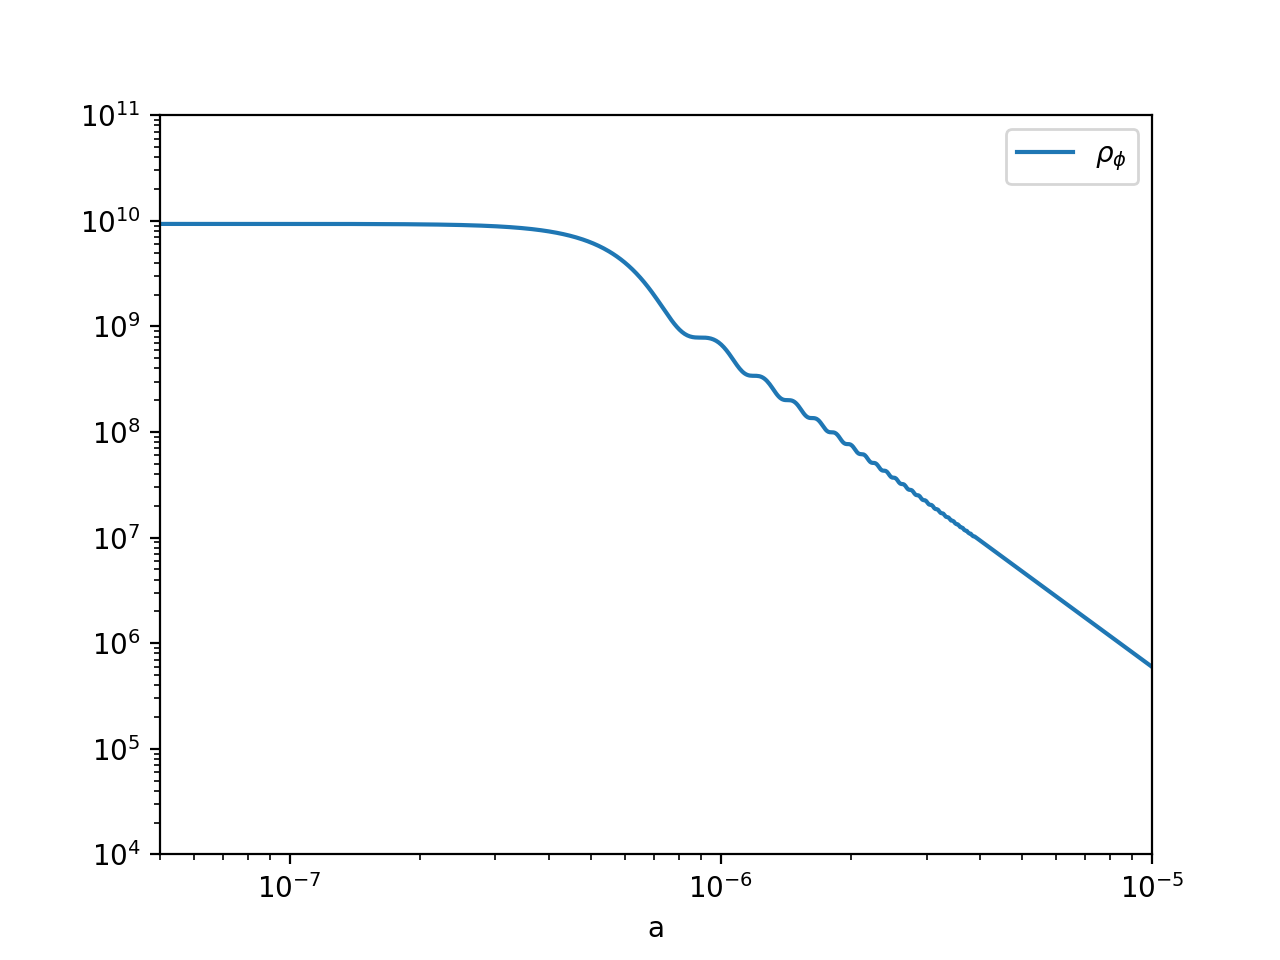

(10000.0, 100000000000.0)

In [22]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('a')
plt.plot(1/(1+background['z'][:]), background['(.)rho_scf'][:], '-', label=r"$\rho_{\phi}$")
plt.legend(loc='best')
plt.xlim(5e-8, 1e-5)
plt.ylim(1e4, 1e11)

<IPython.core.display.Javascript object>


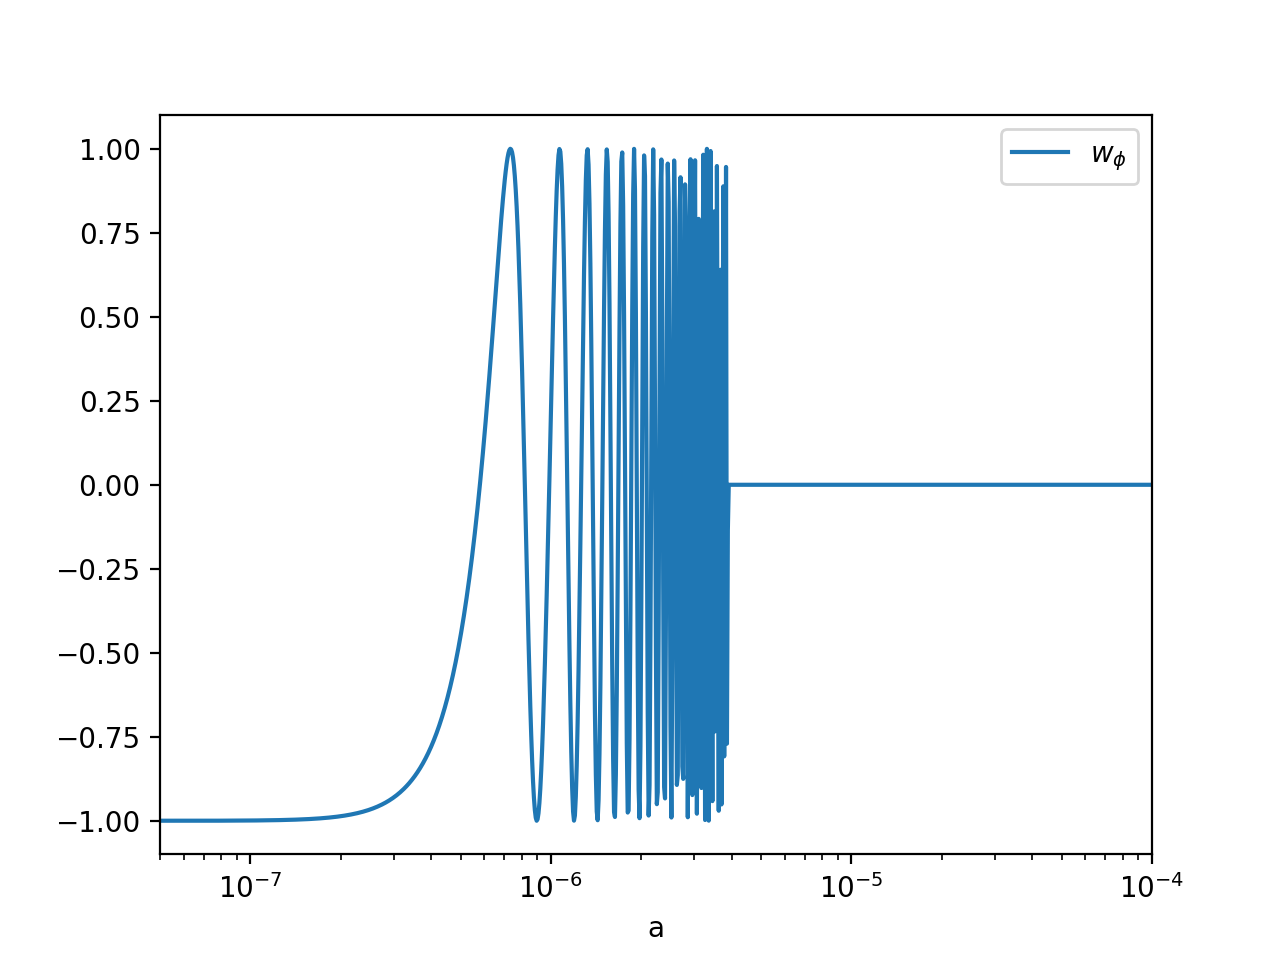

(5e-08, 0.0001)

In [21]:
plt.subplots()
plt.xscale('log')
plt.xlabel('a')
plt.plot(1/(1+background['z'][:]), background['(.)p_scf']/background['(.)rho_scf'], '-', label=r"$w_{\phi}$")
plt.legend(loc='best')
plt.xlim(5e-8, 1e-4)
#plt.ylim(1e4, 1e11)